In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

TEST = False

img_dir = "data/"
if not TEST:
    img_list=["00125v.jpg","00149v.jpg","00153v.jpg","00351v.jpg","00398v.jpg","01112v.jpg"]
else:
    img_list = ["00125v.jpg"]


In [30]:
def crop_img(img):
    h,w = img.shape
    for i in range(h):
        if np.mean(img[i,:]) < 210:
            break

    for j in range(h-1,0,-1):
        if np.mean(img[j,:]) < 210:
            break
    for k in range(w):
        if np.mean(img[:,k]) < 210:
            break
    for d in range(w-1,0,-1):
        if np.mean(img[:,d]) < 210:
            break

    return img[i:j,k:d].copy(),i+(h-j)

In [31]:
def LoG(img):
    img = gaussian_filter(img, sigma=1.5)
    lap_kernal =np.array([  [  0,  0, -1,  0,  0 ],  
                            [  0, -1, -2, -1,  0 ],  
                            [ -1, -2, 16, -2, -1 ], 
                            [  0, -1, -2, -1,  0 ], 
                            [  0,  0, -1,  0,  0 ]])
    lap_kernal2 = np.array([[0,-1,0],[-1,8,-1],[0,-1,0]])
    return cv2.filter2D(cv2.filter2D(img,-1,lap_kernal),-1,lap_kernal2)
    

In [32]:
def offset(img1,img2):
    img1_f = np.fft.fft2(img1)
    img2_f = np.fft.fft2(img2)
    img2_c = np.conjugate(img2_f)
    prod = img1_f * img2_c
    pic = np.fft.fftshift(np.fft.ifft2(prod))
    result = np.unravel_index(np.argmax(pic),pic.shape)
    return [result[0]-img2.shape[0]//2,result[1]-img2.shape[1]//2],np.abs(pic).astype(np.float64)

00125v.jpg [-6, -1] [4, -1]


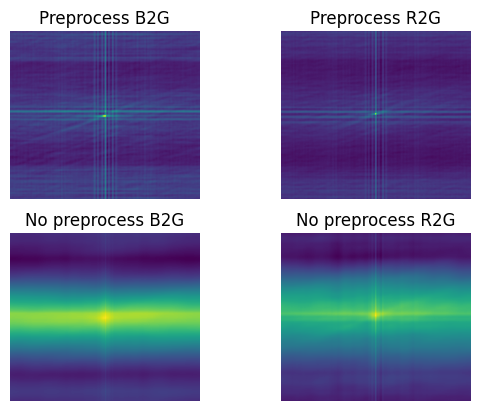

00149v.jpg [-4, -2] [5, 0]


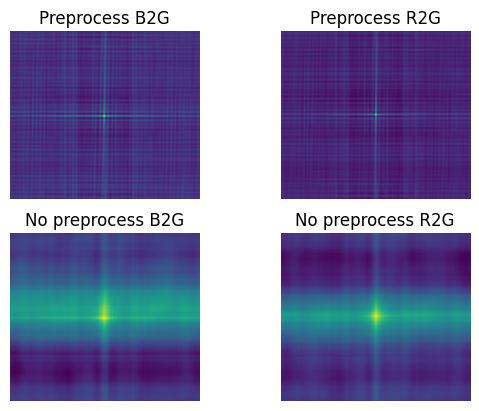

00153v.jpg [-7, -2] [7, 1]


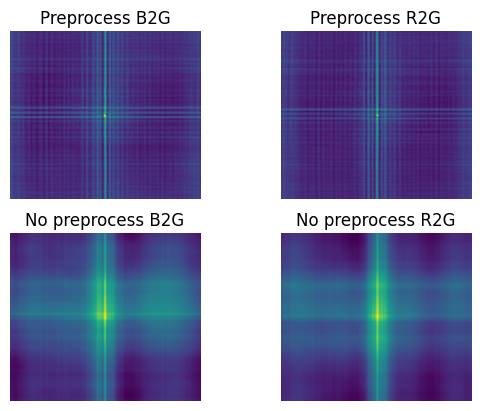

00351v.jpg [-3, 0] [8, 1]


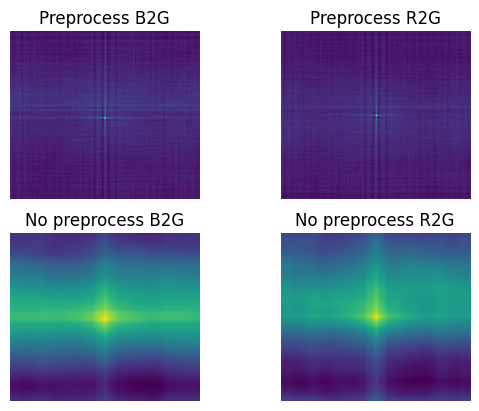

00398v.jpg [-5, -2] [6, 1]


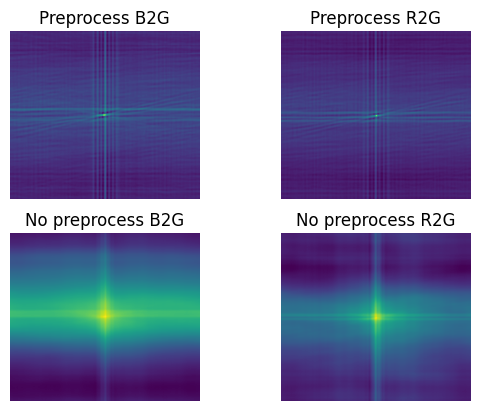

01112v.jpg [0, 0] [5, 1]


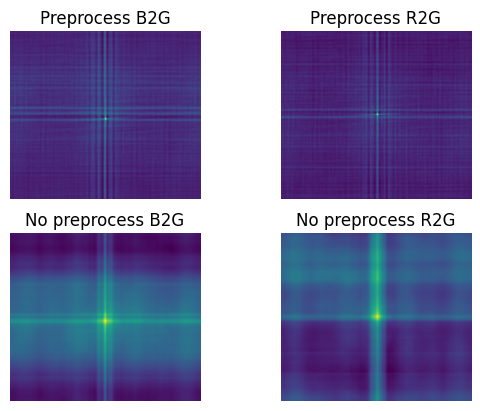

In [36]:
for loc in img_list:
    img1 = cv2.imread(img_dir+loc,cv2.IMREAD_GRAYSCALE)
    img,off = crop_img(img1)
    h = int(img.shape[0]*1/3)
    blue = img[0:h,:]
    blue_L = LoG(blue)
    green = img[h:2*h,:]
    green_L = LoG(green)
    red = img[2*h:3*h,:]
    red_L = LoG(red)
    b2g_L,b2g_L_ifft = offset(green_L,blue_L)
    b2g_L[0] -= off//3 # offset of cropping
    plt.subplot(221)
    plt.imshow(b2g_L_ifft)
    plt.title("Preprocess B2G")
    plt.axis('off')
    r2g_L,r2g_L_ifft = offset(green_L,red_L)
    r2g_L[0] += off//3 # offset of cropping
    plt.subplot(222)
    plt.imshow(r2g_L_ifft)
    plt.title("Preprocess R2G")
    plt.axis('off')
    _,b2g_ifft = offset(green,blue)
    plt.subplot(223)
    plt.imshow(b2g_ifft)
    plt.title("No preprocess B2G")
    plt.axis('off')
    _,r2g_ifft = offset(green,red)
    plt.subplot(224)
    plt.imshow(r2g_ifft)
    plt.title("No preprocess R2G")
    plt.axis('off')
    print(loc,b2g_L,r2g_L)
    
    # we shift with the actual image (channels with original image//3)
    h1 = int(img1.shape[0]*1/3)
    blue = img1[0:h1,:]
    green = img1[h1:2*h1,:]
    red = img1[2*h1:3*h1,:]
    b_off=np.roll(blue,b2g_L,axis=(0,1))
    r_off=np.roll(red,r2g_L,axis=(0,1))
    c_img = (np.dstack((b_off,green,r_off))).astype(np.uint8)
    cv2.imwrite("result/"+loc,c_img)
    plt.axis('off')
    plt.savefig("result/"+"fig_"+loc)
    plt.show()


01047u.tif [25, 19] [71, 33]


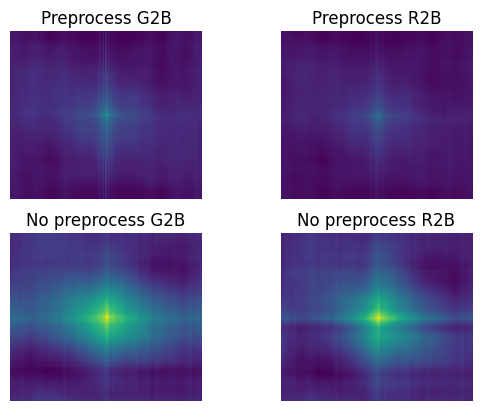

01657u.tif [56, 9] [118, 13]


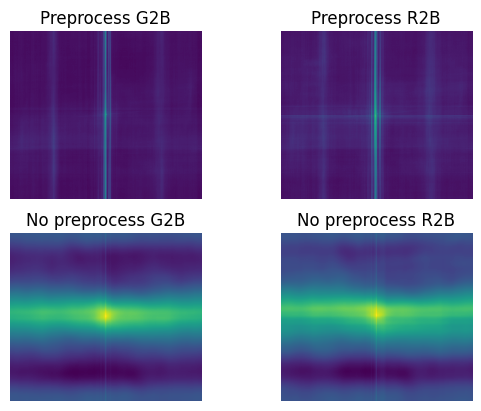

01861a.tif [71, 38] [147, 62]


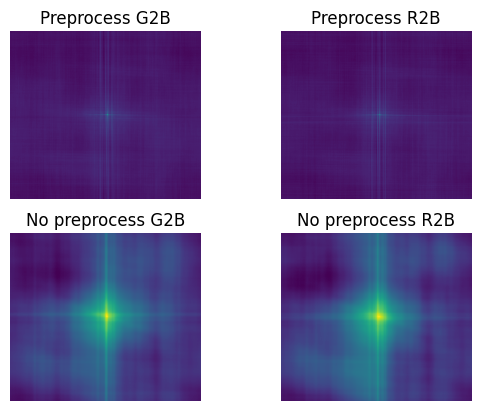

In [39]:
for loc in ["01047u.tif","01657u.tif","01861a.tif"]:
    img1 = cv2.imread(img_dir+loc,cv2.IMREAD_GRAYSCALE)
    img,off = crop_img(img1)
    h = int(img.shape[0]*1/3)
    blue = img[0:h,:]
    blue_L = LoG(blue)
    green = img[h:2*h,:]
    green_L = LoG(green)
    red = img[2*h:3*h,:]
    red_L = LoG(red)
    g2b_L,g2b_L_ifft = offset(blue_L,green_L)
    g2b_L[0] += off//3 # offset of cropping
    plt.subplot(221)
    plt.imshow(g2b_L_ifft)
    plt.title("Preprocess G2B")
    plt.axis('off')
    r2b_L,r2b_L_ifft = offset(blue_L,red_L)
    r2b_L[0] += (off//3)*2 # offset of cropping
    plt.subplot(222)
    plt.imshow(r2b_L_ifft)
    plt.title("Preprocess R2B")
    plt.axis('off')
    _,g2b_ifft = offset(blue,green)
    plt.subplot(223)
    plt.imshow(g2b_ifft)
    plt.title("No preprocess G2B")
    plt.axis('off')
    _,r2b_ifft = offset(blue,red)
    plt.subplot(224)
    plt.imshow(r2b_ifft)
    plt.title("No preprocess R2B")
    plt.axis('off')
    print(loc,g2b_L,r2b_L)
    
    # we shift with the actual image (channels with original image//3)
    h1 = int(img1.shape[0]*1/3)
    blue = img1[0:h1,:]
    green = img1[h1:2*h1,:]
    red = img1[2*h1:3*h1,:]
    g_off=np.roll(green,g2b_L,axis=(0,1))
    r_off=np.roll(red,r2b_L,axis=(0,1))
    c_img = (np.dstack((blue,g_off,r_off))).astype(np.uint8)
    cv2.imwrite("result/"+loc,c_img)
    plt.savefig("result/"+"fig_"+loc[0:6]+".jpg")
    plt.show()


In [26]:
for loc in ["01047u.tif","01657u.tif","01861a.tif"]:
    img1 = cv2.imread(img_dir+loc,cv2.IMREAD_GRAYSCALE)
    img = crop_img(img1)
    h = int(img.shape[0]*1/3)
    blue = img[0:h,:]
    blue_L = LoG(blue)
    green = img[h:2*h,:]
    green_L = LoG(green)
    red = img[2*h:3*h,:]
    red_L = LoG(red)
    g2b_L,g2b_L_ifft = offset(blue_L,green_L)
    # plt.subplot(221)
    # plt.imshow(g2b_L_ifft)
    # plt.title("Preprocess G2B")
    # plt.axis('off')
    r2b_L,r2b_L_ifft = offset(blue_L,red_L)
    # plt.subplot(222)
    # plt.imshow(r2b_L_ifft)
    # plt.title("Preprocess R2B")
    # plt.axis('off')
    g2b,g2b_ifft = offset(blue,green)
    # plt.subplot(223)
    # plt.imshow(g2b_ifft)
    # plt.title("No preprocess G2B")
    # plt.axis('off')
    r2b,r2b_ifft = offset(blue,red)
    # plt.subplot(224)
    # plt.imshow(r2b_ifft)
    # plt.title("No preprocess R2B")
    # plt.axis('off')
    print(loc,g2b_L,r2b_L)
    g_off=np.roll(green,g2b_L,axis=(0,1))
    r_off=np.roll(red,r2b_L,axis=(0,1))
    c_img = (np.dstack((blue,g_off,r_off))).astype(np.uint8)
    cv2.imwrite(loc,c_img)
    #plt.savefig("result/"+"fig_"+loc[0:6]+".jpg")
    # plt.show()


32 52 31 68
01047u.tif (25, 19) (71, 33)
82 127 84 98
01657u.tif (59, -10) (213, -21)
142 90 64 102
01861a.tif (71, 38) (147, 62)


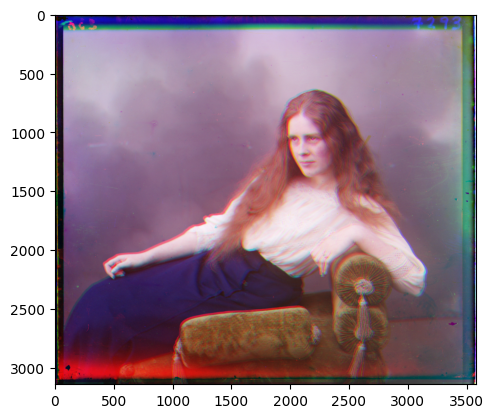

In [232]:
img = cv2.imread(img_dir+"01657u.tif",cv2.IMREAD_GRAYSCALE)
img = crop_img(img)
h = int(img.shape[0]*1/3)
blue = img[0:h,:]
green = img[h:2*h,:]
red = img[2*h:3*h,:]
g2b_L,g2b_L_ifft = offset(blue,green)
r2b_L,r2b_L_ifft = offset(blue,red)
g_off=np.roll(green,g2b_L,axis=(0,1))
r_off=np.roll(red,r2b_L,axis=(0,1))
c_img = (np.dstack((r_off,g_off,blue))).astype(np.uint8)
plt.imshow(c_img)